In [5]:
import vitaldb
import numpy as np
import pandas as pd
import scipy.signal as ss
from scipy.ndimage import minimum_filter1d, maximum_filter1d
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm.auto import tqdm
import random

# colorblind friendly palette
import matplotlib as mpl
cp = ["#172A5A", "#FF7171", "#227567", "#34BAEA", "#F9D466", ]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=cp)

# set default font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Open Sans', 'Arial']
plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
def um(ta=None, tb=None, data=[[], [], []], t=[]):
    ta = ta if ta else t.min()
    tb = tb if tb else t.max()
    twin = (t >= ta) & (t <= tb)

    plt.figure(figsize=(12,8), dpi=100)
    for i, sig in enumerate(data):
        sig = np.ma.masked_invalid(sig)
        plt.subplot(3,1,i+1)
        plt.plot(t[twin], sig[twin], lw=1, c=cp[i])
        sns.despine(bottom=i<2)
        if i<2: plt.xticks([])
        plt.xlim(ta, tb)
        plt.tight_layout()
        plt.show()

In [3]:
df_trks = pd.read_csv('https://api.vitaldb.net/trks')  # read track list
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # read case information

In [4]:
caseids = list(
    set(df_trks[df_trks['tname'] == 'SNUADC/ART']['caseid']) &
    set(df_trks[df_trks['tname'] == 'SNUADC/ECG_II']['caseid']) &
    set(df_trks[df_trks['tname'] == 'SNUADC/PLETH']['caseid']) &
    set(df_cases[df_cases['age'] > 18]['caseid']) &
    set(df_cases[df_cases['age'] >= 18]['caseid']) & 
    set(df_cases[df_cases['weight'] >= 30]['caseid']) & 
    set(df_cases[df_cases['weight'] < 140]['caseid']) & 
    set(df_cases[df_cases['height'] >= 135]['caseid']) & 
    set(df_cases[df_cases['height'] < 200]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("transplant", case=False)]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("aneurysm", case=False)]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("aorto", case=False)]['caseid'])& 
    set(df_cases[df_cases['ane_type'] == 'General']['caseid'])
)
print('Total {} cases found'.format(len(caseids)))

Total 3235 cases found


In [53]:
def interpolate_fix(art, ppg):
    ppg_new = ppg.copy()
    art_new = art.copy()
    
    nan_indices = np.isnan(ppg_new)
    non_nan_indices = np.arange(len(ppg_new))[~nan_indices]
    non_nan_values_ppg = ppg_new[~nan_indices]
    non_nan_values_art = art_new[~nan_indices]
    
    interp_val_ppg = np.interp(nan_indices.nonzero()[0], non_nan_indices, non_nan_values_ppg)
    interp_val_art = np.interp(nan_indices.nonzero()[0], non_nan_indices, non_nan_values_art)
    
    ppg_new[nan_indices] = interp_val_ppg
    art_new[nan_indices] = interp_val_art
    
    return art_new, ppg_new

In [55]:
random_inds = random.sample(range(3235), 10)
fs = 125

for ind in random_inds:
    track_names = ['ECG_II', 'ART', 'PLETH']
    vf = vitaldb.VitalFile(caseids[2552], track_names) 
    data = vf.to_numpy(track_names, 1/fs)
    t = np.arange(data.shape[0]) / fs
    
    ecg, art, ppg = data[:, 0], data[:, 1], data[:, 2]
    
    art, ppg = interpolate_fix(art, ppg)
    
    fourier_coeffs_art = np.fft.fft(art)
    fourier_coeffs_ppg = np.fft.fft(ppg)
    
    print(f'Number of ART NaNs: {np.count_nonzero(np.isnan(art))}', end = "\n")
    print(f'Number of PPG NaNs: {np.count_nonzero(np.isnan(ppg))}', end = "\n")
    print(f'Percent NaN: {np.count_nonzero(np.isnan(ppg)) / len(np.isnan(ppg))}', end = "\n")
    print(f'Length: {len(np.isnan(ppg))}', end = "\n")   

    
    plt.figure(figsize=(8,4))
    plt.subplot(2,1,1)
    plt.plot(t, art, lw=1, label = "Original ART")
    #plt.xlim([0, len(ppg)])
    sns.despine()
    plt.gca().margins(0)
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(np.abs(fourier_coeffs_art), label='real part')
    plt.legend()
    plt.show()
    
    # plt.figure(figsize=(8,4))
    # plt.subplot(2,1,1)
    # plt.plot(t, ppg, lw=1, label = "Original PPG")
    # #plt.xlim([0, len(ppg)])
    # sns.despine()
    # plt.gca().margins(0)
    # plt.legend()
    # plt.subplot(2, 1, 2)
    # plt.plot(np.abs(fourier_coeffs_ppg), label='real part')
    # plt.legend()
    # plt.show()
    break

ValueError: array of sample points is empty

In [15]:
import numpy as np
import pandas as pd

from neurodsp.filt import filter_signal
from neurodsp.plts import plot_time_series
from neurodsp.sim import sim_combined

from bycycle import Bycycle
from bycycle.cyclepoints import find_extrema, find_zerox
from bycycle.cyclepoints.zerox import find_flank_zerox
from bycycle.plts import plot_cyclepoints_array
from bycycle.utils.download import load_bycycle_data

pd.options.display.max_columns = 10

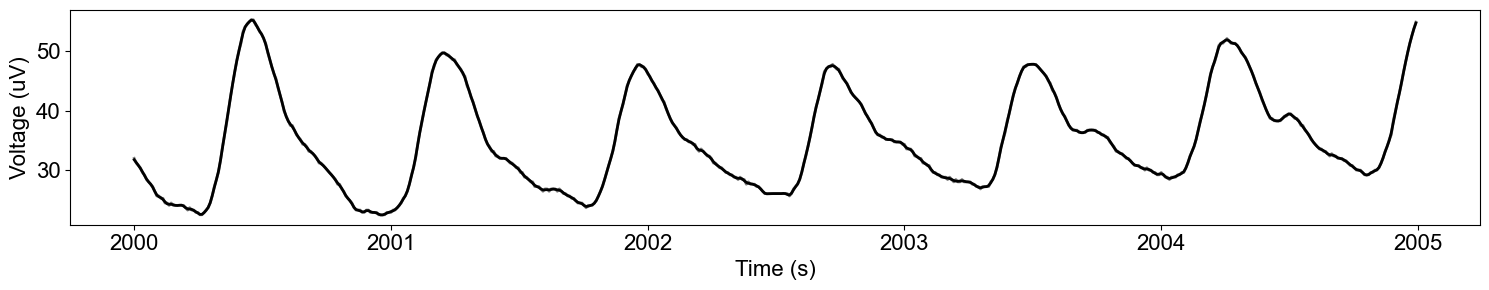

In [22]:
# Load data
# sig = load_bycycle_data('ca1.npy', folder='data')
# fs = 1250

track_names = ['ECG_II', 'ART', 'PLETH']
vf = vitaldb.VitalFile(caseids[3125], track_names) 
data = vf.to_numpy(track_names, 1/fs)
t = np.arange(data.shape[0]) / fs

ecg, art, ppg = data[:, 0], data[:, 1], data[:, 2]

fs = 125
sig = ppg

# Filter settings
f_theta = (0.5, 8)
f_lowpass = 30
n_seconds_filter = .1

# # Lowpass filter
# sig_low = filter_signal(sig, fs, 'lowpass', f_lowpass,
#                         n_seconds=n_seconds_filter, remove_edges=False)

# Plot signal
times = np.arange(0, len(sig)/fs, 1/fs)
xlim = (2000, 2005)
tidx = np.logical_and(times >= xlim[0], times < xlim[1])

plot_time_series(times[tidx], [sig[tidx]], colors=['k'], alpha=[.5], lw=2)

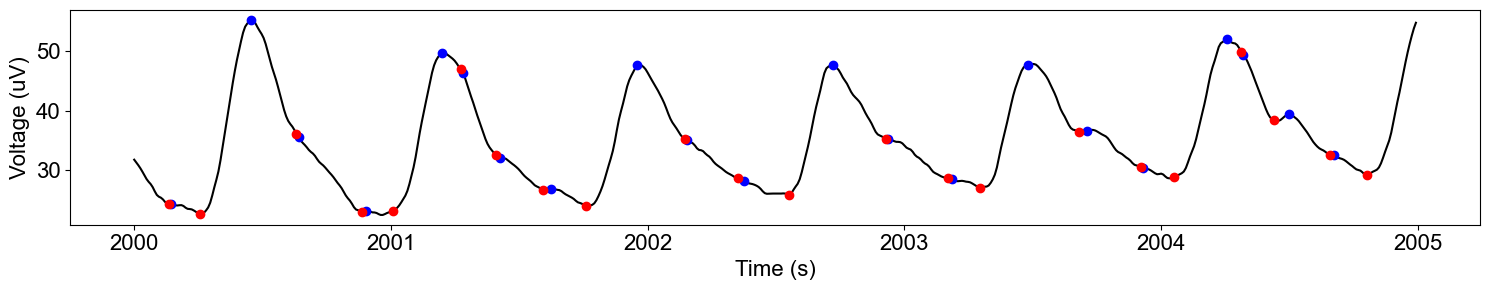

In [32]:
# Narrowband filter signal
n_seconds_theta = 0.75

sig_narrow = filter_signal(sig, fs, 'bandpass', f_theta,
                           n_seconds=n_seconds_theta, remove_edges=False)

# Find rising and falling zerocrossings (narrowband)
rise_xs = find_flank_zerox(sig_narrow, 'rise')
decay_xs = find_flank_zerox(sig_narrow, 'decay')

# Find peaks and troughs (this function also does the above)
peaks, troughs = find_extrema(sig, fs, f_theta,
                              filter_kwargs={'n_seconds':n_seconds_theta})
plot_cyclepoints_array(sig_low, fs, peaks=peaks, troughs=troughs, xlim=(2000, 2005))

In [33]:
# Load NeuroKit and other useful packages
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt

In [51]:
track_names = ['ECG_II', 'ART', 'PLETH']
vf = vitaldb.VitalFile(caseids[1000], track_names) 
data = vf.to_numpy(track_names, 1/fs)
t = np.arange(data.shape[0]) / fs

ecg, art, ppg = data[:, 0], data[:, 1], data[:, 2]

fs = 500
sig = ppg

0


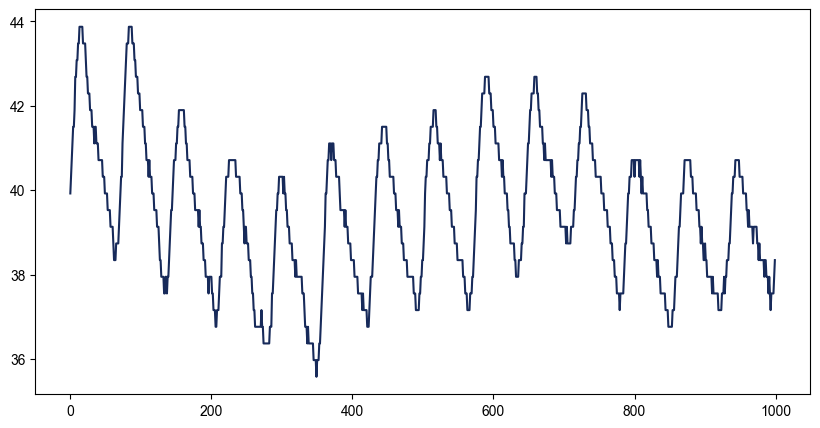

In [52]:
sig = ppg[100000:101000]
print(np.count_nonzero(np.isnan(sig)))
plt.plot(sig)

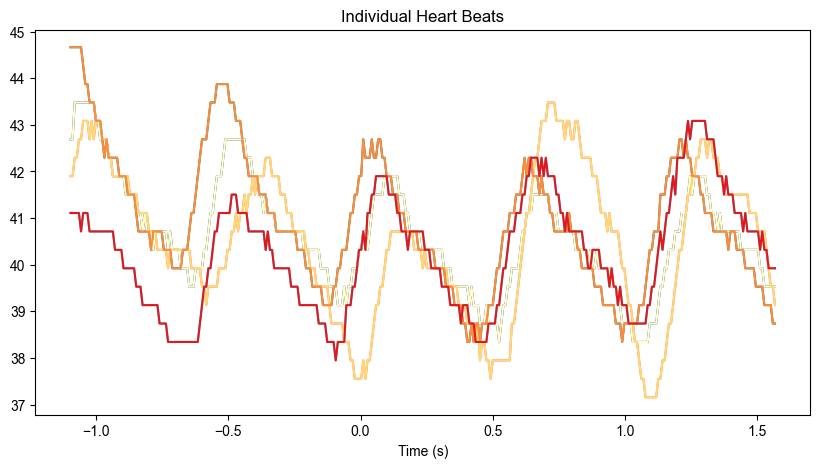

In [49]:
#sig = nk.ecg_simulate(duration=30, sampling_rate=250)
epochs = nk.ecg_segment(sig, rpeaks=None, sampling_rate=125, show=True)
